In [0]:
import zipfile
f = zipfile.ZipFile("drive/My Drive/additional/train.zip")
f.extractall("./datasets")

In [2]:
import glob
import pandas as pd
catfs = glob.glob("datasets/train/cat.*.[jJ][pP][gG]")
catans = [0] * len(catfs)
dogfs = glob.glob("datasets/train/dog.*.[jJ][pP][gG]")
dogans = [1] * len(dogfs)
df = pd.DataFrame({
    "path":catfs + dogfs,
    "target":catans + dogans
})
df

,path,target
0,datasets/train/cat.11630.jpg,0
1,datasets/train/cat.3765.jpg,0
2,datasets/train/cat.591.jpg,0
3,datasets/train/cat.6686.jpg,0
4,datasets/train/cat.2384.jpg,0
...,...,...
24995,datasets/train/dog.9502.jpg,1
24996,datasets/train/dog.10694.jpg,1
24997,datasets/train/dog.7585.jpg,1
24998,datasets/train/dog.1878.jpg,1


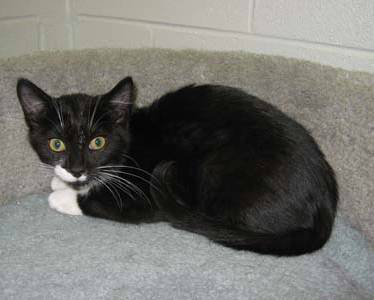

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img
idx = 1
load_img(df["path"][idx])

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
cnn.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

for l in cnn.layers:
    # !!! trainable一定要先設置
    l.trainable = False
x = Flatten()(cnn.output)
x = Dense(128, activation="relu")(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [0]:
# 訓練以前, 把所有的list, series.... -> nparray
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(df["target"]),
                                                    test_size=0.1)

In [0]:
# 請使用裡面的預處理(不要自己來)
from tensorflow.keras.applications.vgg16 import preprocess_input
# return: (原圖(batch), 處理後圖(batch), 答案(batch))
def dataflow(x, y, batch=20):
    idx = np.random.randint(0, x.shape[0], size=batch)
    x_batch, y_batch = x[idx], y[idx]
    x_ori, x_pre = [], []
    for fp in x_batch:
        img = load_img(fp, target_size=(224, 224))
        img_np = np.array(img)
        # 原本的圖片我存一份
        x_ori.append(img_np)
        img_pre = preprocess_input(img_np)
        # 預處理的圖片
        x_pre.append(img_pre)
    x_ori, x_pre = np.array(x_ori), np.array(x_pre)
    return (x_ori, x_pre, y_batch)